In [61]:
from sympy import symbols
from sympy.plotting import plot
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math
import pandas as pd

import PIL
import tensorflow as tf
import os, warnings

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_hub as hub

## Importing the dataset

Firstly, the data should be imported into the pandas dataframes for easy manipulation. 

In [62]:
batch_size = 32
data_dir = "data"
img_height = 224
img_width = 224

df_train_ = image_dataset_from_directory(
    data_dir,

    validation_split=0.2,
    subset="training",

    labels='inferred',
    label_mode='binary',

    image_size=[img_height, img_width],
    batch_size=batch_size,

    seed = 123,     
    interpolation='nearest',
    shuffle=True
)

df_valid_ = image_dataset_from_directory(
    data_dir,

    validation_split=0.2,
    subset="validation",

    labels='inferred',
    label_mode='binary',

    image_size=[img_height, img_width],
    batch_size=batch_size,

    seed = 123,     
    interpolation='nearest',
    shuffle=False
)


Found 1536 files belonging to 2 classes.
Using 1229 files for training.
Found 1536 files belonging to 2 classes.
Using 307 files for validation.


In [63]:
class_names = df_train_.class_names
print(class_names)

['linear', 'quadratic']


## Dataset Optimization

In [64]:
AUTOTUNE = tf.data.AUTOTUNE

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

df_train = (
    df_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
df_valid = (
    df_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

## Model Definition

In [65]:

model = tf.keras.Sequential([
    hub.KerasLayer(
        "https://www.kaggle.com/models/tensorflow/resnet-50/frameworks/TensorFlow2/variations/feature-vector/versions/1",
        trainable=False
        ),  
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

2024-03-01 19:17:14.777017: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [66]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

In [67]:
history = model.fit(
    df_train,
    validation_data=df_valid,
    epochs=3
    )

Epoch 1/3
39/39 [==============================] - 51s 1s/step - loss: 0.1029 - binary_accuracy: 0.9683 - val_loss: 0.0044 - val_binary_accuracy: 1.0000
Epoch 2/3
39/39 [==============================] - 46s 1s/step - loss: 0.0022 - binary_accuracy: 1.0000 - val_loss: 0.0023 - val_binary_accuracy: 1.0000
Epoch 3/3
39/39 [==============================] - 50s 1s/step - loss: 0.0014 - binary_accuracy: 1.0000 - val_loss: 0.0016 - val_binary_accuracy: 1.0000


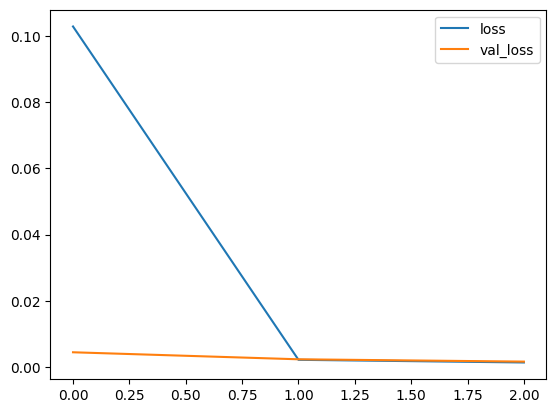

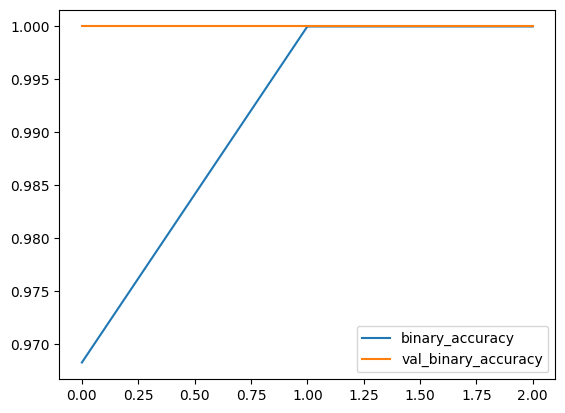

In [68]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();